# Adjust threshold for VTDR AI model in Lifeline Express Cohort

## 0 Prepare Environment

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
import sys as sys
import time as time
#from sklearn.metrics import confusion_matrix

In [2]:
#from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.datasets import load_iris
#from sklearn.metrics import plot_confusion_matrix

## 1 Define Fuction

### Define function for plotting confusion matrix

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        #print('显示具体数字：')
        print(cm)
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.style.use('default')
    plt.savefig(plotpath+'.pdf')
    plt.show()

### Value R0-R1 as 0, R2-R4 as 1

In [4]:
def label_column(df,value_column,label_column):
    df.loc[(df[value_column]=='R0')  | (df[value_column]=='R1'), label_column] = 0
    df.loc[(df[value_column]=='R2')  | (df[value_column]=='R3') | (df[value_column]=='R4'), label_column] = 1
    return

### Define function to adjust threshold

In [5]:
def AdjustThreshold(R0_threshold,R1_threshold,R2_threshold,R3_threshold,R4_threshold):
    time_start = datetime.datetime.now()
    
    """
    - Set R2-R4 threshold, probability lower than the threshold will be changed to 0
    """
    # Turn probability less than threshold into zero
    df = ROCdata.copy(deep=True)
    df.loc[df['prob_dr_result_R0']<R0_threshold, 'prob_dr_result_R0'] = 0
    df.loc[df['prob_dr_result_R1']<R1_threshold, 'prob_dr_result_R1'] = 0
    df.loc[df['prob_dr_result_R2']<R2_threshold, 'prob_dr_result_R2'] = 0
    df.loc[df['prob_dr_result_R3']<R3_threshold, 'prob_dr_result_R3'] = 0
    df.loc[df['prob_dr_result_R4']<R4_threshold, 'prob_dr_result_R4'] = 0
    
    # Find colname with the max value of R0-R4
    label_new = df[['prob_dr_result_R0','prob_dr_result_R1','prob_dr_result_R2','prob_dr_result_R3','prob_dr_result_R4']].idxmax(axis=1)
    label = label_new.to_frame()
    label = label[0].str.rsplit('_', expand=True, n=-1)
    # Got new predicted label here
    df['pred_label_dr_new']=label[3]
    
    # Define ai_result & manual_result
    label_column(df=df,value_column = 'manual_dr',label_column = 'manual_result')
    label_column(df=df,value_column = 'pred_label_dr',label_column = 'ai_result_old')
    label_column(df=df,value_column = 'pred_label_dr_new',label_column = 'ai_result_new')

    #---Select patient with at least one figure positive----------------------------------#
    dr_AIPositive_vid = df[(df['ai_result_new']==1)]['vid'].unique()
    All_vid = df['vid'].unique()
    dr_AINegative_vid = np.array(list(set(All_vid).difference(set(dr_AIPositive_vid))))
    dr_ManualPositive_vid = df[(df['manual_result']==1)]['vid'].unique()
    dr_ManualNegative_vid = np.array(list(set(All_vid).difference(set(dr_ManualPositive_vid))))
    
    vid_aiP_manualP = np.array(list(set(dr_AIPositive_vid).intersection(set(dr_ManualPositive_vid))))
    vid_aiP_manualN = np.array(list(set(dr_AIPositive_vid).intersection(set(dr_ManualNegative_vid))))
    vid_aiN_manualP = np.array(list(set(dr_AINegative_vid).intersection(set(dr_ManualPositive_vid))))
    vid_aiN_manualN = np.array(list(set(dr_AINegative_vid).intersection(set(dr_ManualNegative_vid))))
    
    # Calculate result
    TP = (len(vid_aiP_manualN)+len(vid_aiP_manualP)/old_FPtoTP_rate)*old_FPtoTP_rate*rate
    FP = len(vid_aiP_manualN)-(TP-len(vid_aiP_manualP))
    TP_GT = round(TP+Ungradable_TP,0)
    TN_GT = round(len(vid_aiN_manualN) + (len(vid_aiN_manualP)-rate*old_FNtoTN_rate*(len(vid_aiN_manualP)/(old_FNtoTN_rate)-len(vid_aiN_manualP))),0)
    FP_GT = round(FP+Ungradable_FP,0)
    FN_GT = round(len(vid_aiN_manualP)-(len(vid_aiN_manualP)-rate*old_FNtoTN_rate*(len(vid_aiN_manualP)/(old_FNtoTN_rate)-len(vid_aiN_manualP))),0)
    sensitivity = TP_GT/(TP_GT+FN_GT)
    specificity = TN_GT/(TN_GT+FP_GT)
    
    time_end = datetime.datetime.now()
    Time = time_end - time_start
    
    return sensitivity,specificity,TP_GT,TN_GT,FP_GT,FN_GT,Time

### Define progress bar

In [6]:
def progress_bar():
        print("\r", end="")
        print("Running progress: {}%: ".format(i), "▋" * (i // 2), end="")
        sys.stdout.flush()
        time.sleep(0.05)

### Define ICER computation

In [7]:
def Compute_ICER(table_sort_origin,WTP):
    ICER_change = 1
    table_sort = table_sort_origin.copy(deep=True)
    
    #table_sort = table_sort.drop(table_sort.index[100])
    table_sort['Incre.Cost'] = ""
    table_sort['Incre.Effect'] = ""
    table_sort['ICER'] = ""
    
    
    while ICER_change > 0:
        ICER_change = 0
        drop_list_ICER = []
    
        # Compute ICER
        for i in range(len(table_sort.index)):
            if i > 0:
                table_sort.loc[table_sort.index[i],'Incre.Cost'] = table_sort.loc[table_sort.index[i],'Cost'] - table_sort.loc[table_sort.index[i-1],'Cost']
                table_sort.loc[table_sort.index[i],'Incre.Effect'] = table_sort.loc[table_sort.index[i],'Effect'] - table_sort.loc[table_sort.index[i-1],'Effect']           
                table_sort.loc[table_sort.index[i],'ICER'] = table_sort.loc[table_sort.index[i],'Incre.Cost']/table_sort.loc[table_sort.index[i],'Incre.Effect']
    
        # Find ICER exceed WTP
        for j in range(len(table_sort.index)):
            if j > 0:
                if table_sort.loc[table_sort.index[j],'ICER'] > WTP:
                    drop_list_ICER.append(j)
    
        # Drop ICER exceed WTP
        table_sort = table_sort.drop(table_sort.index[drop_list_ICER])
        ICER_change = len(drop_list_ICER)
    
        # Reset index
        table_sort.reset_index(drop=True, inplace=True)
    
    Min_spe = table_sort.loc[len(table_sort.index)-1,'Specificity']
    return Min_spe,table_sort

## 2 Data preparation

In [8]:
# Read Data
ROCdata = pd.read_csv('./DataForPy/ROCdata.csv')
ROCdata = ROCdata.drop(['Unnamed: 0'], axis=1)
#ROCdata[:3]

ROCdata.loc[ROCdata['manual_dr']=='R3a',['manual_dr']]='R3'
ROCdata.loc[ROCdata['manual_dr']=='R3s',['manual_dr']]='R4'

# Confusion matrix for R0-R4 categories
y_pred = ROCdata['pred_label_dr'].values.tolist()
y_test = ROCdata['manual_dr'].values.tolist()

con_mat = confusion_matrix(y_test, y_pred,labels=["R0", "R1", "R2","R3","R4"])
attack_types = ['R0','R1','R2','R3','R4']
# === plot ===
plot_confusion_matrix(con_mat, classes=attack_types, normalize=False) # y_pred R2 has most prediction mistakes

NameError: name 'confusion_matrix' is not defined

[[ 16974    715]
 [ 32140 187995]]


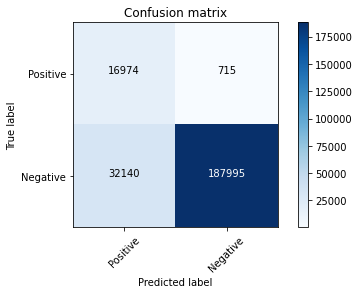

In [9]:
path = "./DataForPy"
filename = "ConfusionMatrix_PatientLevel_Postcorrection"
plotpath = os.path.join(path, filename)
# Draw confusion matrix for Biclassification
con_mat = np.array([[16974,715],
                   [32140,187995]])
attack_types = ['Positive','Negative']
# === plot ===
plot_confusion_matrix(con_mat, classes=attack_types, normalize=False) # y_pred R2 has most prediction mistakes

## 3 Initialize parameters

### Initialize threshold adjustment parameters

In [573]:
# Initialize empty table
table = pd.DataFrame()

#### Urban Rural Different Parameters (choose 1 in 3)

In [360]:
# Rural, population = 24229
new_prevalence = 0.054

# Compliance
p_AcceptReferral = 0.33
p_AcceptTreatment = 0.50

# Costs
c_DLscreening = 8
c_examination = 306
c_InitialTreat = 2274
c_FollowTreat = 882

In [377]:
# Urban, population = 209598
new_prevalence = 0.0809

# Compliance
p_AcceptReferral = 0.57
p_AcceptTreatment = 0.75

# Costs
c_DLscreening = 12.59
c_examination = 172
c_InitialTreat = 2249
c_FollowTreat = 748

In [574]:
# Overall, population = 251535
new_prevalence = 0.0798 # !! Input new prevalence here

# Compliance
p_AcceptReferral = 0.5
p_AcceptTreatment = 0.7

# Costs
c_DLscreening = 10.65
c_examination = 185
c_InitialTreat = 2252
c_FollowTreat = 763

#### Choose a prevalence

In [575]:
old_prevalence = 0.0744
rate = 1

In [576]:
# Run the followings after inputting new prevalence
# Initialize parameters


Ungradable_TP = 13711*old_prevalence
Ungradable_FP = 13711*(1-old_prevalence)


rate_1 = new_prevalence/old_prevalence

old_FPtoTP_rate = 0.0513
old_FNtoTN_rate = 0.653249

### Initialize CEA parameters

In [577]:
# Prevalence
p_NonVTDR = 1-new_prevalence
p_VTDRnotTreat = 0
p_VTDRtreat = 0
p_blind = 0
  
# Transition probability
p_healthy_to_VTDR = 0.07
p_Treated_to_blind = 0.02
p_VTDR_to_blind = 0.09

# Initial costs
c_Non_VTDR_Screening = 0
c_VTDR_Screening = 0
c_VTDRtreat = 0
c_blind = 0

# Effectiveness
e_Non_VTDR = 0.87
e_VTDR = 0.83
e_VTDRtreat = 0.85
e_blind = 0.55

# Blindness Costs 
c_InitialBlind = 8920
c_FollowBlind = 3604

# Discount
cost_discount = 0.03
effect_discount = 0.035

In [564]:
# Mortality For Main Analysis
mortality = pd.DataFrame(data=[0.007686,0.00854,0.009394,0.012789,0.01421,0.015631,0.028341,0.03149,0.034639,0.043749,0.04861,0.053471,0.080388,0.08932,0.098252,0.080388,0.08932,0.098252,0.080388,0.08932,0.098252],columns = ['mortality'])
mortality

,mortality
0,0.007686
1,0.008540
2,0.009394
3,0.012789
4,0.014210
5,0.015631
6,0.028341
7,0.031490
8,0.034639
9,0.043749


In [578]:
# Mortality for Age subgroup analysis
mortality = pd.DataFrame(data=[0.000330,0.000390,0.000510,0.000780 ,0.001250 ,0.001940 ,0.003640 ,0.005180 ,0.008540 ,0.014210 ,0.031490 ,0.048610 ,0.089320,0.089320,0.089320,0.089320,0.089320,0.089320,0.089320,0.089320],columns = ['mortality'])
mortality

# Define start age
age = 60 # ! Input new age here

def AgeMortality(stage):
    i = int((stage+age-20)/5)
    m = mortality.loc[i,'mortality']
    p_healthy_to_die = m*1.8
    p_VTDR_to_die = m*1.76*1.8
    p_Treated_to_die = m*1.76*1.8
    p_blind_to_die = m*2.34*1.8
    return p_healthy_to_die,p_VTDR_to_die,p_Treated_to_die,p_blind_to_die

In [565]:
def AgeMortality(stage):
    i = (int(stage/5)+1)*3-2
    m = mortality.loc[i,'mortality']
    p_healthy_to_die = m*1.8
    p_VTDR_to_die = m*1.76*1.8
    p_Treated_to_die = m*1.76*1.8
    p_blind_to_die = m*2.34*1.8
    return p_healthy_to_die,p_VTDR_to_die,p_Treated_to_die,p_blind_to_die

## 4 Define CEA calculation functions

In [256]:
def HealthyProgression(rate_1,stage):
    # Mortality due to stage
    p_healthy_to_die = AgeMortality(stage)[0]

    healthy = rate_1 * (1-p_healthy_to_VTDR-p_healthy_to_die)
    VTDR = rate_1 * p_healthy_to_VTDR
    die = rate_1 * p_healthy_to_die
    return healthy,VTDR,die

def VTDRProgression(rate_1,stage):
    # Mortality due to stage
    p_VTDR_to_die = AgeMortality(stage)[1]

    VTDR = rate_1 * (1-p_VTDR_to_blind-p_VTDR_to_die)
    blind = rate_1 * p_VTDR_to_blind
    die = rate_1 * p_VTDR_to_die
    return VTDR,blind,die

def TreatProgression(rate_1,stage):
    # Mortality due to stage
    p_Treated_to_die = AgeMortality(stage)[2]
    
    Treat = rate_1 * (1-p_Treated_to_blind-p_Treated_to_die)
    blind = rate_1 * p_Treated_to_blind
    die = rate_1 * p_Treated_to_die
    return Treat,blind,die

In [257]:
def FILL_CEA_DF(CEA,sensitivity,specificity,stage):
    #====PROBABILITY====#
    

    # 1. AI-Negative-TN
    
    CEA.loc[6,'PROBABILITY'] = CEA.loc[0,'PROBABILITY'] * specificity # Probability: AI-Negative/TN
    CEA.loc[7,'PROBABILITY'] = HealthyProgression(CEA.loc[6,'PROBABILITY'],stage)[0] # Probability: AI-Negative/TN--Stay healthy
    CEA.loc[8,'PROBABILITY'] = HealthyProgression(CEA.loc[6,'PROBABILITY'],stage)[1] # Probability: AI-Negative/TN--Progress to VTDR-undetected
    CEA.loc[9,'PROBABILITY'] = HealthyProgression(CEA.loc[6,'PROBABILITY'],stage)[2] # Probability: AI-Negative/TN--Die
    
    # 2. AI-Positive-FP
    CEA.loc[10,'PROBABILITY'] = CEA.loc[0,'PROBABILITY'] * (1-specificity) # Probability: AI-Positive/FP
    ## Accept Referral
    CEA.loc[11,'PROBABILITY'] = CEA.loc[10,'PROBABILITY'] * p_AcceptReferral # Probability: AI-Positive/FP--Accept Referral-healthy
    CEA.loc[12,'PROBABILITY'] = HealthyProgression(CEA.loc[11,'PROBABILITY'],stage)[0] # Probability: AI-Positive/FP--Accept Referral-healthy--Stay healthy
    CEA.loc[13,'PROBABILITY'] = HealthyProgression(CEA.loc[11,'PROBABILITY'],stage)[1] # Probability: AI-Positive/FP--Accept Referral-healthy--Progress to VTDR-undetected
    CEA.loc[14,'PROBABILITY'] = HealthyProgression(CEA.loc[11,'PROBABILITY'],stage)[2] # Probability: AI-Positive/FP--Accept Referral-healthy--Die
    ## Reject Referral
    CEA.loc[15,'PROBABILITY'] = CEA.loc[10,'PROBABILITY'] * (1-p_AcceptReferral) # Probability: AI-Positive/FP--Reject Referral
    CEA.loc[16,'PROBABILITY'] = HealthyProgression(CEA.loc[15,'PROBABILITY'],stage)[0] # Probability: AI-Positive/FP--Reject Referral--Stay healthy
    CEA.loc[17,'PROBABILITY'] = HealthyProgression(CEA.loc[15,'PROBABILITY'],stage)[1] # Probability: AI-Positive/FP--Reject Referral--Progress to VTDR-undetected
    CEA.loc[18,'PROBABILITY'] = HealthyProgression(CEA.loc[15,'PROBABILITY'],stage)[2] # Probability: AI-Positive/FP--Reject Referral-healthy--Die
    
    # 3. AI-Positive/TP
    CEA.loc[19,'PROBABILITY'] = CEA.loc[1,'PROBABILITY'] * sensitivity # Probability: AI-Positive/TP
    ## Accept Referral
    ### Accept Treatment
    CEA.loc[20,'PROBABILITY'] = CEA.loc[19,'PROBABILITY'] * p_AcceptReferral # Probability: AI-Positive/TP--AcceptReferral
    CEA.loc[21,'PROBABILITY'] = CEA.loc[20,'PROBABILITY'] * p_AcceptTreatment # Probability: AI-Positive/TP--AcceptTreatment
    CEA.loc[22,'PROBABILITY'] = TreatProgression(CEA.loc[21,'PROBABILITY'],stage)[0] # Probability: AI-Positive/TP--AcceptTreatment--Treated VTDR
    CEA.loc[23,'PROBABILITY'] = TreatProgression(CEA.loc[21,'PROBABILITY'],stage)[1] # Probability: AI-Positive/TP--AcceptTreatment-Treated VTDR to blind
    CEA.loc[24,'PROBABILITY'] = TreatProgression(CEA.loc[21,'PROBABILITY'],stage)[2] # Probability: AI-Positive/TP--AcceptTreatment--Die
    
    ### Reject Treatment
    CEA.loc[25,'PROBABILITY'] = CEA.loc[20,'PROBABILITY'] * (1-p_AcceptTreatment) # Probability: AI-Positive/TP--RejectTreatment
    CEA.loc[26,'PROBABILITY'] = VTDRProgression(CEA.loc[25,'PROBABILITY'],stage)[0] # Probability: AI-Positive/TP--RejectTreatment--Detected but not treated VTDR
    CEA.loc[27,'PROBABILITY'] = VTDRProgression(CEA.loc[25,'PROBABILITY'],stage)[1] # Probability: AI-Positive/TP--RejectTreatment-Detected but not treated VTDR to blind
    CEA.loc[28,'PROBABILITY'] = VTDRProgression(CEA.loc[25,'PROBABILITY'],stage)[2] # Probability: AI-Positive/TP--RejectTreatment--Die
    ## Reject Referral
    CEA.loc[29,'PROBABILITY'] = CEA.loc[19,'PROBABILITY'] * (1-p_AcceptReferral) # Probability: AI-Positive/TP--RejectReferral
    CEA.loc[30,'PROBABILITY'] = VTDRProgression(CEA.loc[29,'PROBABILITY'],stage)[0] # Probability: AI-Positive/TP--RejectReferral--VTDR
    CEA.loc[31,'PROBABILITY'] = VTDRProgression(CEA.loc[29,'PROBABILITY'],stage)[1] # Probability: AI-Positive/TP--RejectReferral-VTDR to blind
    CEA.loc[32,'PROBABILITY'] = VTDRProgression(CEA.loc[29,'PROBABILITY'],stage)[2] # Probability: AI-Positive/TP--RejectReferral--Die
    
    # 4. AI-Negative/FN
    CEA.loc[33,'PROBABILITY'] = CEA.loc[1,'PROBABILITY'] * (1-sensitivity) # Probability: AI-Negative/FN
    CEA.loc[34,'PROBABILITY'] = VTDRProgression(CEA.loc[33,'PROBABILITY'],stage)[0] # Probability: AI-Negative/FN--VTDR
    CEA.loc[35,'PROBABILITY'] = VTDRProgression(CEA.loc[33,'PROBABILITY'],stage)[1] # Probability: AI-Negative/FN--blind
    CEA.loc[36,'PROBABILITY'] = VTDRProgression(CEA.loc[33,'PROBABILITY'],stage)[2] # Probability: AI-Negative/FN--Die
    
    # 5. VTDR detected but not treated
    CEA.loc[37,'PROBABILITY'] = VTDRProgression(CEA.loc[2,'PROBABILITY'],stage)[0] # Probability: VTDR detected but not treated
    CEA.loc[38,'PROBABILITY'] = VTDRProgression(CEA.loc[2,'PROBABILITY'],stage)[1] # Probability: VTDR detected but not treated--blind
    CEA.loc[39,'PROBABILITY'] = VTDRProgression(CEA.loc[2,'PROBABILITY'],stage)[2] # Probability: VTDR detected but not treated--Die
    
    # 6. VTDR treated
    CEA.loc[40,'PROBABILITY'] = TreatProgression(CEA.loc[3,'PROBABILITY'],stage)[0] # Probability: Treated VTDR
    CEA.loc[41,'PROBABILITY'] = TreatProgression(CEA.loc[3,'PROBABILITY'],stage)[1] # Probability: Treated VTDR--blind
    CEA.loc[42,'PROBABILITY'] = TreatProgression(CEA.loc[3,'PROBABILITY'],stage)[2] # Probability: Treated VTDR--Die
    
    # 7. Blind
    # Mortality due to stage
    p_blind_to_die = AgeMortality(stage)[3]
    CEA.loc[43,'PROBABILITY'] = CEA.loc[4,'PROBABILITY']*(1-p_blind_to_die) # Probability: Treated VTDR--blind
    CEA.loc[44,'PROBABILITY'] = CEA.loc[4,'PROBABILITY'] * p_blind_to_die # Probability: Treated VTDR--Die
    
    
    #====Cost AND EFFECTIVENESS====#
    CEA['COST'] = CEA['PROBABILITY'] * CEA['COSTENTRY']
    CEA['EFFECTIVENESS'] = CEA['PROBABILITY'] * CEA['EFFECTIVENESSENTRY']

In [258]:
def CEA_Next(CEA,CEA_NextStage,sensitivity,specificity,stage):    
    
    # Initialize Next Stage Parameters
    ## Probability
    CEA_NextStage.loc[0,'PROBABILITY'] = CEA.loc[7,'PROBABILITY'] + CEA.loc[12,'PROBABILITY'] + CEA.loc[16,'PROBABILITY'] # Probability: Non-VTDR-Screening
    CEA_NextStage.loc[1,'PROBABILITY'] = CEA.loc[8,'PROBABILITY'] + CEA.loc[13,'PROBABILITY'] + CEA.loc[17,'PROBABILITY'] + CEA.loc[30,'PROBABILITY'] + CEA.loc[34,'PROBABILITY'] # Probability: VTDR-Undetected-Screening
    CEA_NextStage.loc[2,'PROBABILITY'] = CEA.loc[26,'PROBABILITY'] + CEA.loc[37,'PROBABILITY'] # Probability: VTDR Detected but not treated
    CEA_NextStage.loc[3,'PROBABILITY'] = CEA.loc[22,'PROBABILITY'] + CEA.loc[40,'PROBABILITY'] # Probability: VTDR treated
    CEA_NextStage.loc[4,'PROBABILITY'] = CEA.loc[23,'PROBABILITY'] + CEA.loc[27,'PROBABILITY'] + CEA.loc[31,'PROBABILITY'] + CEA.loc[35,'PROBABILITY']+ CEA.loc[38,'PROBABILITY']+ CEA.loc[41,'PROBABILITY']+ CEA.loc[43,'PROBABILITY'] # Probability: blind
    CEA_NextStage.loc[5,'PROBABILITY'] = CEA.loc[9,'PROBABILITY'] + CEA.loc[14,'PROBABILITY'] + CEA.loc[18,'PROBABILITY'] + CEA.loc[24,'PROBABILITY']+ CEA.loc[28,'PROBABILITY']+ CEA.loc[32,'PROBABILITY']+ CEA.loc[36,'PROBABILITY'] + CEA.loc[39,'PROBABILITY']+ CEA.loc[42,'PROBABILITY']+ CEA.loc[44,'PROBABILITY'] # Probability: blind
    
    ## Cost
    CEA_NextStage.loc[3,'COSTENTRY'] = c_FollowTreat/((1+cost_discount)**stage) # Follow-up treatment cost-discount
    CEA_NextStage.loc[4,'COSTENTRY'] = c_FollowBlind/((1+cost_discount)**stage) # Follow-up blindness cost-discount
    
    ## Effectiveness
    CEA_NextStage.loc[0,'EFFECTIVENESSENTRY'] = e_Non_VTDR/((1+effect_discount)**stage) # Healthy effectiveness-discount
    CEA_NextStage.loc[1,'EFFECTIVENESSENTRY'] = e_VTDR/((1+effect_discount)**stage) # VTDR effectiveness-discount
    CEA_NextStage.loc[2,'EFFECTIVENESSENTRY'] = e_VTDR/((1+effect_discount)**stage) # VTDR not treated effectiveness-discount
    CEA_NextStage.loc[3,'EFFECTIVENESSENTRY'] = e_VTDRtreat/((1+effect_discount)**stage) # Treated VTDR effectiveness-discount
    CEA_NextStage.loc[4,'EFFECTIVENESSENTRY'] = e_blind/((1+effect_discount)**stage) # Blind effectiveness-discount
    
    FILL_CEA_DF(CEA_NextStage,sensitivity,specificity,stage)

In [566]:
CEA_INIT = pd.read_csv('./DataForPy/CEA_TEMPLATE.csv')

In [567]:
CEA_INIT.loc[0,'PROBABILITY'] = 1-new_prevalence
CEA_INIT.loc[1,'PROBABILITY'] = new_prevalence

CEA_INIT.loc[0,'COSTENTRY'] = c_DLscreening
CEA_INIT.loc[1,'COSTENTRY'] = c_DLscreening
CEA_INIT.loc[3,'COSTENTRY'] = c_FollowTreat
CEA_INIT.loc[11,'COSTENTRY'] = c_examination
CEA_INIT.loc[20,'COSTENTRY'] = c_examination
CEA_INIT.loc[21,'COSTENTRY'] = c_InitialTreat

CEA_INIT

,EVENTID,NODENAME,NODETYPE,PROBABILITY,COSTENTRY,COST,EFFECTIVENESSENTRY,EFFECTIVENESS
0,1,Non-VTDR-Screening,ChanceNode,0.88,10.65,NaN,0.435,NaN
1,2,VTDR-undetected-Screening,ChanceNode,0.12,10.65,NaN,0.415,NaN
2,3,VTDR-detected but not treated,ChanceNode,0.00,0.00,NaN,0.415,NaN
3,4,VTDR-detected&treated,ChanceNode,0.00,763.00,NaN,0.425,NaN
4,5,Blindness,ChanceNode,0.00,8920.00,NaN,0.275,NaN
5,6,Die,TerminalNode,0.00,0.00,NaN,0.000,NaN
6,7,AI-Negative/TN,ChanceNode,NaN,0.00,NaN,0.000,NaN
7,8,Stay healthy,TerminalNode,NaN,0.00,NaN,0.000,NaN
8,9,Progress to VTDR-undetected,TerminalNode,NaN,0.00,NaN,0.000,NaN
9,10,Die,TerminalNode,NaN,0.00,NaN,0.000,NaN


In [261]:
def CEA_Calculation(sensitivity,specificity):    
    CEA = CEA_INIT.copy(deep=True)
    CEA.loc[0,'PROBABILITY'] = p_NonVTDR
    CEA.loc[1,'PROBABILITY'] = new_prevalence
    #print("sensitivity: "+str(sensitivity)+", specificity: "+str(specificity))
    
    # Cycle 0
    FILL_CEA_DF(CEA,sensitivity,specificity,0) 
    
    CEA_result = CEA.copy(deep=True)

    # Cycle 1 to 29
    for stage in range(1,30,1):
        CEA_NextStage = CEA.copy(deep=True)
        
        #print("stage: "+str(stage))
        CEA_Next(CEA,CEA_NextStage,sensitivity,specificity,stage)
        
        CEA_result = pd.concat([CEA_result,CEA_NextStage])
        CEA = CEA_NextStage.copy(deep=True)
        
    stage = stage+1
    CEA_NextStage = CEA.copy(deep=True)
    CEA_Next(CEA,CEA_NextStage,sensitivity,specificity,stage)
    # Half-cycle correction at last stage
    CEA_NextStage['EFFECTIVENESS'] = CEA_NextStage['EFFECTIVENESS']/2
    CEA_NextStage['EFFECTIVENESSENTRY'] = CEA_NextStage['EFFECTIVENESSENTRY']/2
    CEA_NextStage = CEA_NextStage.loc[:5]
    CEA_result = pd.concat([CEA_result,CEA_NextStage])
    CEA_result.reset_index(drop=True, inplace=True)
        
    cost = CEA_result['COST'].sum()
    effectiveness = CEA_result['EFFECTIVENESS'].sum()
    
    return cost,effectiveness

## 5 Test Threshold and output plots & results

### Test threshold for R2-R4
to decrease FP (increase specificity)

In [568]:
new_prevalence

0.12

In [238]:
# Test threshold for R2-R4, 1000 iterations
for R2 in range(10):
    R2_threshold = R2/10
    
    for R3 in range(10):
        R3_threshold = R3/10
        
        for R4 in range(10):
            R4_threshold = R4/10
            
            R0_threshold = 0
            R1_threshold = 0
            
            # Show progress
            i = R2*10+R3+1
            if __name__ == '__main__':
                progress_bar()
                
            # Run function
            Calculate_result = AdjustThreshold(R0_threshold,R1_threshold,R2_threshold,R3_threshold,R4_threshold)
            
            #if (round(Calculate_result[0],6) == 0.961783) & (round(Calculate_result[1],6) == 0.807444) : # if sensitivity and specificity not changed, skip
                #continue
            
            # === plot confusion matrix===
            #con_mat = np.array([[int(Calculate_result[2]),int(Calculate_result[5])],[int(Calculate_result[4]),int(Calculate_result[3])]])
            #attack_types = ['Positive','Negative']
            #threshold = "R0-R4_"+str(R0_threshold)+"_"+str(R1_threshold)+"_"+str(R2_threshold)+"_"+str(R3_threshold)+"_"+str(R4_threshold)
            
            # Define figure path
            #path = './Plot'
            #filename = "Threshold_"+threshold+".png"
            #plotpath = os.path.join(path, filename)
            #plot_confusion_matrix(con_mat, classes=attack_types, normalize=False)
            
            # Save result
            result = {"R0":R0_threshold,"R1":R1_threshold,"R2":R2_threshold,"R3":R3_threshold,"R4":R4_threshold,"Sensitivity":Calculate_result[0],"Specificity":Calculate_result[1],"TP":Calculate_result[2],"TN":Calculate_result[3],"FP":Calculate_result[4],"FN":Calculate_result[5],"Time":Calculate_result[6]}
            table = table.append(result,ignore_index = True)

Running progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

### Test threshold for R0-R1
to decrease FN (increase sensitivity)

In [244]:
#Initialize empty table_1 to store R0-R1 results
table_1 = pd.DataFrame()

# Test threshold for R0-R1, 100 iterations
for R0 in range(10):
    R0_threshold = R0/10
    
    for R1 in range(10):
        R1_threshold = R1/10
        
        R2_threshold = 0
        R3_threshold = 0
        R4_threshold = 0
        
        # Show progress
        i = R0*10+R1+1
        if __name__ == '__main__':
            progress_bar()
            
        # Run function
        Calculate_result = AdjustThreshold(R0_threshold,R1_threshold,R2_threshold,R3_threshold,R4_threshold)
            
        # Save result
        result = {"R0":R0_threshold,"R1":R1_threshold,"R2":R2_threshold,"R3":R3_threshold,"R4":R4_threshold,"Sensitivity":Calculate_result[0],"Specificity":Calculate_result[1],"TP":Calculate_result[2],"TN":Calculate_result[3],"FP":Calculate_result[4],"FN":Calculate_result[5],"Time":Calculate_result[6]}
        table_1 = table_1.append(result,ignore_index = True)

Running progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

In [246]:
# Combine two result
table = pd.concat([table,table_1])
table.reset_index(drop=True, inplace=True)

In [569]:
table = pd.read_csv('./DataForPy/TableSenSpe.csv')
table

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect
0,715.0,44832.0,0.0,0.0,0.0,0.0,0.0,0.961783,0.807444,187994.0,17994.0,0 days 00:00:04.377606,NaN,NaN
1,715.0,44832.0,0.0,0.0,0.0,0.0,0.1,0.961783,0.807444,187994.0,17994.0,0 days 00:00:04.772368,NaN,NaN
2,715.0,44832.0,0.0,0.0,0.0,0.0,0.2,0.961783,0.807444,187994.0,17994.0,0 days 00:00:04.105735,NaN,NaN
3,715.0,44823.0,0.0,0.0,0.0,0.0,0.3,0.961783,0.807483,188003.0,17994.0,0 days 00:00:03.409213,NaN,NaN
4,721.0,44677.0,0.0,0.0,0.0,0.0,0.4,0.961425,0.808125,188167.0,17970.0,0 days 00:00:03.472127,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,159.0,152894.0,0.9,0.5,0.0,0.0,0.0,0.993789,0.323283,73041.0,25441.0,0 days 00:00:03.206496,NaN,NaN
1096,155.0,153348.0,0.9,0.6,0.0,0.0,0.0,0.993953,0.321178,72555.0,25477.0,0 days 00:00:03.213146,NaN,NaN
1097,151.0,153616.0,0.9,0.7,0.0,0.0,0.0,0.994114,0.319925,72265.0,25503.0,0 days 00:00:03.221711,NaN,NaN
1098,150.0,153765.0,0.9,0.8,0.0,0.0,0.0,0.994155,0.319238,72107.0,25513.0,0 days 00:00:03.212696,NaN,NaN


### Calculate cost and effectiveness in sole AI CEA model

In [570]:
for index in table.index:
    COST_EFFECT = CEA_Calculation(table.loc[index,'Sensitivity'],table.loc[index,'Specificity'])
    table.loc[index,'Cost'] = COST_EFFECT[0]
    table.loc[index,'Effect'] = COST_EFFECT[1]
    
    # Show progress
    i = int(100*index/len(table.index))+1
    if __name__ == '__main__':
        progress_bar()

Running progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

In [387]:
CEA_Calculation(0.963014209,0.803930499)

(6334.961013209186, 9.195388897646774)

In [186]:
CEA_Calculation(0.965952081,0.791615592)

(6282.936924686501, 9.172550734399072)

CEA_Calculation(0.961783,0.807444) # Reference-No adjustment

## 6 Export Result Table

In [388]:
prev_name = round(new_prevalence*100,2)
outputpath='./DataForPy/Threshold_CEA_Result_Urban_R0-R4.csv'
table.to_csv(outputpath,sep=',',index=False,header=True)

In [ ]:
outputpath='./DataForPy/Threshold_CEA_Result_prev'+str(prev_name)+'_R0-R4.csv'

## 7 Draw ROC & CEA plot

### Prepare table for ROC and CEA plots

In [571]:
# CEA plot table sort
table_sort = table.sort_values(['Cost'],ascending=True, inplace=False)
table_sort.reset_index(drop=True, inplace=True)

change = 1

while change > 0 :
    change = 0
    index_list = table_sort.index
    drop_list = []
    
    for i in range(len(index_list)):
        
        if i > 0:
            a = table_sort.loc[table_sort.index[i-1],'Effect']
            b = table_sort.loc[table_sort.index[i],'Effect']
            
            if (b < a) | (b == a):
                drop_list.append(i)
            
    table_sort = table_sort.drop(table_sort.index[drop_list])
    change = len(drop_list)
                
    index_list = table_sort.index
                
table_sort

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect
0,3575.0,17674.0,0.0,0.0,0.9,0.9,0.9,0.698414,0.926260,222007.0,8279.0,0 days 00:00:03.753863,6574.788291,9.055936
1,3491.0,17746.0,0.0,0.0,0.9,0.8,0.9,0.709447,0.925910,221774.0,8524.0,0 days 00:00:04.572724,6575.332360,9.057791
2,3360.0,17903.0,0.0,0.0,0.9,0.7,0.9,0.726161,0.925175,221362.0,8910.0,0 days 00:00:03.903804,6576.250588,9.060540
3,3191.0,18157.0,0.0,0.0,0.9,0.6,0.9,0.746766,0.924008,220777.0,9410.0,0 days 00:00:03.700363,6577.485508,9.063828
4,2973.0,18566.0,0.0,0.0,0.9,0.5,0.9,0.771922,0.922155,219934.0,10062.0,0 days 00:00:03.483835,6579.190701,9.067702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,159.0,152894.0,0.9,0.5,0.0,0.0,0.0,0.993789,0.323283,73041.0,25441.0,0 days 00:00:03.206496,7036.655370,9.096275
1096,155.0,153348.0,0.9,0.6,0.0,0.0,0.0,0.993953,0.321178,72555.0,25477.0,0 days 00:00:03.213146,7038.266642,9.096293
1097,151.0,153616.0,0.9,0.7,0.0,0.0,0.0,0.994114,0.319925,72265.0,25503.0,0 days 00:00:03.221711,7039.223946,9.096311
1098,150.0,153765.0,0.9,0.8,0.0,0.0,0.0,0.994155,0.319238,72107.0,25513.0,0 days 00:00:03.212696,7039.749723,9.096315


In [405]:
Compute_ICER(table_sort,30828)[1]
# Rural WTP: 25751
# Urban WTP: 37259

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect,Incre.Cost,Incre.Effect,ICER
0,1146.0,28935.0,0.0,0.0,0.9,0.0,0.6,0.932743,0.876608,205561.0,15893.0,0 days 00:00:03.399672,18225.977911,14.808126,,,
1,1097.0,29878.0,0.0,0.0,0.9,0.0,0.5,0.936150,0.872509,204476.0,16084.0,0 days 00:00:03.260246,18226.448743,14.808844,0.470832,0.000717868,655.876
2,1060.0,30692.0,0.0,0.0,0.9,0.0,0.4,0.938704,0.868973,203550.0,16233.0,0 days 00:00:03.573230,18227.319429,14.809380,0.870686,0.00053533,1626.45
3,1033.0,31271.0,0.0,0.0,0.9,0.0,0.3,0.940550,0.866454,202888.0,16343.0,0 days 00:00:03.450662,18227.914427,14.809765,0.594998,0.000385883,1541.91
4,1007.0,31711.0,0.0,0.0,0.9,0.0,0.2,0.942289,0.864533,202375.0,16442.0,0 days 00:00:03.256425,18227.991099,14.810128,0.0766717,0.000362331,211.607
5,983.0,32144.0,0.0,0.0,0.9,0.0,0.0,0.943889,0.862642,201872.0,16536.0,0 days 00:00:03.476130,18228.198849,14.810460,0.20775,0.000332664,624.503
6,977.0,32930.0,0.0,0.0,0.8,0.0,0.3,0.944400,0.859251,201033.0,16595.0,0 days 00:00:03.539419,18231.289766,14.810566,3.09092,0.000105972,29167.3
7,952.0,33362.0,0.0,0.0,0.8,0.0,0.2,0.946041,0.857362,200530.0,16691.0,0 days 00:00:03.288988,18231.455930,14.810906,0.166164,0.0003399,488.86
8,933.0,33676.0,0.0,0.0,0.8,0.0,0.0,0.947270,0.855988,200165.0,16761.0,0 days 00:00:03.803392,18231.537839,14.811160,0.0819095,0.00025411,322.339
9,910.0,35202.0,0.0,0.0,0.7,0.0,0.3,0.948937,0.849380,198512.0,16911.0,0 days 00:00:03.909594,18236.800652,14.811504,5.26281,0.000343683,15313


In [230]:
# ROC plot table sort
table_roc = table.sort_values(['Sensitivity'],ascending=True, inplace=False)
table_roc['1-Specificity'] = 1-table_roc['Specificity']
table_roc.reset_index(drop=True, inplace=True)

roc_change = 1

while roc_change > 0 :
    roc_change = 0
    index_list = table_roc.index
    drop_list_roc = []
    
    for i in range(len(index_list)):
        
        if i > 0:
            a = table_roc.loc[table_roc.index[i-1],'1-Specificity']
            b = table_roc.loc[table_roc.index[i],'1-Specificity']
            
            if a > b:
                drop_list_roc.append(i-1)
            
    table_roc = table_roc.drop(table_roc.index[drop_list_roc])
    roc_change = len(drop_list_roc)
                
    index_list = table_roc.index
                
table_roc

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect,1-Specificity
0,3575,17674,0.0,0.0,0.9,0.9,0.9,0.698414,0.926260,222007,8279,0 days 00:00:03.187216,6165.482832,9.137628,0.073740
1,3491,17746,0.0,0.0,0.9,0.8,0.9,0.709447,0.925910,221774,8524,0 days 00:00:05.424024,6166.469975,9.139366,0.074090
2,3360,17903,0.0,0.0,0.9,0.7,0.9,0.726161,0.925175,221362,8910,0 days 00:00:05.556381,6168.055428,9.141942,0.074825
3,3191,18157,0.0,0.0,0.9,0.6,0.9,0.746766,0.924008,220777,9410,0 days 00:00:03.195093,6170.103512,9.145024,0.075992
8,2973,18566,0.0,0.0,0.9,0.5,0.9,0.771922,0.922155,219934,10062,0 days 00:00:03.115816,6172.790010,9.148655,0.077845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,159,152894,0.9,0.5,0.0,0.0,0.0,0.993789,0.323283,73041,25441,0 days 00:00:04.697001,6660.879596,9.175477,0.676717
1069,155,153348,0.9,0.6,0.0,0.0,0.0,0.993953,0.321178,72555,25477,0 days 00:00:05.324629,6662.578888,9.175494,0.678822
1070,151,153616,0.9,0.7,0.0,0.0,0.0,0.994114,0.319925,72265,25503,0 days 00:00:03.033999,6663.590251,9.175510,0.680075
1071,150,153765,0.9,0.8,0.0,0.0,0.0,0.994155,0.319238,72107,25513,0 days 00:00:05.185877,6664.144406,9.175515,0.680762


In [231]:
table_roc.to_csv("./DataForPy/table_roc.csv",sep=',',index=False,header=True)

In [870]:
# Slice values not cost-effective

#table
#list = np.array(list(set(table.index).difference(set(table_sort.index))))
#table.iloc[list]['Sensitivity'].max()

0.9617830990432412

In [232]:
# Find ROC plt cutoff point
table_roc['c'] = table_roc['Sensitivity']-table_roc['1-Specificity']
table_roc[table_roc['c'] == table_roc['c'].max()]['Sensitivity']

cutoff_index = table_roc[table_roc['c'] == table_roc['c'].max()].index[0]
best_sensitivity = table_roc.loc[cutoff_index,'Sensitivity']
best_specificity = table_roc.loc[cutoff_index,'Specificity']

print("Best sensitivity: "+str(best_sensitivity))
print("Best Specificity: "+str(best_specificity))

Best sensitivity: 0.932742532
Best Specificity: 0.876607703


In [280]:
table_roc

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect,1-Specificity,c
0,3575,17674,0.0,0.0,0.9,0.9,0.9,0.698414,0.926260,222007,8279,0 days 00:00:03.187216,6165.482832,9.137628,0.073740,0.624674
1,3491,17746,0.0,0.0,0.9,0.8,0.9,0.709447,0.925910,221774,8524,0 days 00:00:05.424024,6166.469975,9.139366,0.074090,0.635357
2,3360,17903,0.0,0.0,0.9,0.7,0.9,0.726161,0.925175,221362,8910,0 days 00:00:05.556381,6168.055428,9.141942,0.074825,0.651336
3,3191,18157,0.0,0.0,0.9,0.6,0.9,0.746766,0.924008,220777,9410,0 days 00:00:03.195093,6170.103512,9.145024,0.075992,0.670774
8,2973,18566,0.0,0.0,0.9,0.5,0.9,0.771922,0.922155,219934,10062,0 days 00:00:03.115816,6172.790010,9.148655,0.077845,0.694077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,159,152894,0.9,0.5,0.0,0.0,0.0,0.993789,0.323283,73041,25441,0 days 00:00:04.697001,6660.879596,9.175477,0.676717,0.317072
1069,155,153348,0.9,0.6,0.0,0.0,0.0,0.993953,0.321178,72555,25477,0 days 00:00:05.324629,6662.578888,9.175494,0.678822,0.315131
1070,151,153616,0.9,0.7,0.0,0.0,0.0,0.994114,0.319925,72265,25503,0 days 00:00:03.033999,6663.590251,9.175510,0.680075,0.314039
1071,150,153765,0.9,0.8,0.0,0.0,0.0,0.994155,0.319238,72107,25513,0 days 00:00:05.185877,6664.144406,9.175515,0.680762,0.313393


#### Draw ROC plot

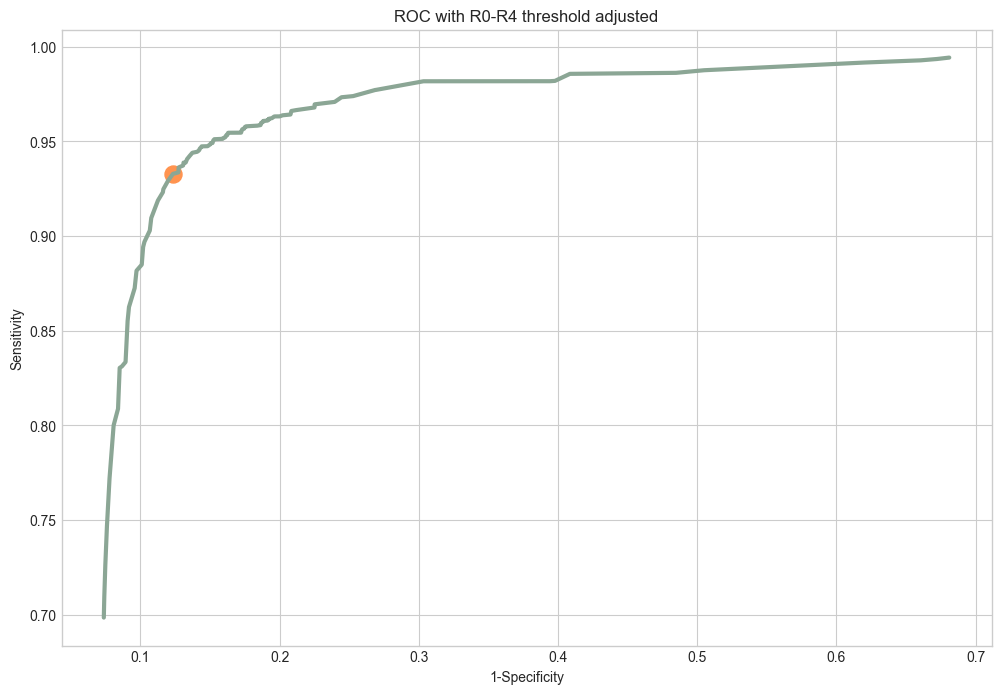

In [277]:
# ROC plt
plt.figure(figsize=(12, 8))
plt.plot(table_roc['1-Specificity'], table_roc['Sensitivity'], '#8BA695', linestyle="-",linewidth = 3)
plt.scatter(1-best_specificity,best_sensitivity,color="#FF934F",s=150)
plt.title('ROC with R0-R4 threshold adjusted')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.style.use('seaborn-whitegrid')
#plt.xlim((0, 1))
#plt.ylim((0, 1))

path = './Plot'
filename = "ROC with R0-R4 threshold adjusted"+str(prev_name)+".pdf"
plotpath = os.path.join(path, filename)
plt.savefig(plotpath)
plt.show()

In [235]:
table_roc[table_roc['c'] == table_roc['c'].max()]

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,TP,Time,Cost,Effect,1-Specificity,c
293,1146,28935,0.0,0.0,0.9,0.0,0.6,0.932743,0.876608,205561,15893,0 days 00:00:05.732505,6213.979858,9.168913,0.123392,0.80935


### Draw CEA plot

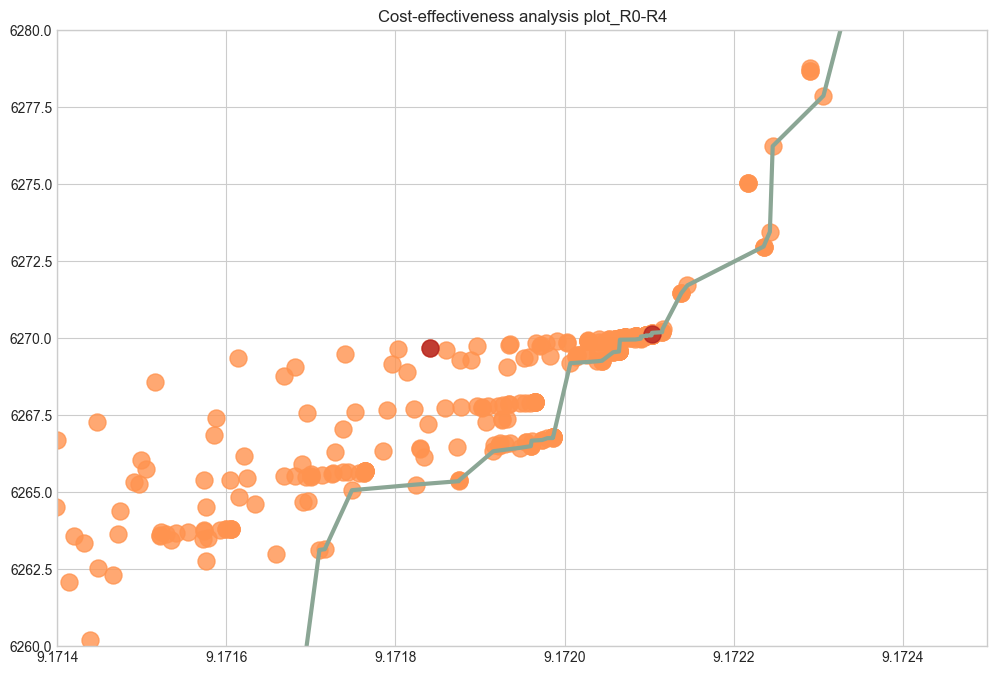

In [558]:
# CEA plt
plt.figure( figsize=(12, 8))
plt.title('Cost-effectiveness analysis plot_R0-R4')

plt.scatter(table['Effect'], table['Cost'],color = "#FF934F",s=150,alpha = 0.8)
plt.plot(table_sort['Effect'], table_sort['Cost'], color='#8BA695', marker="",linestyle="-",linewidth = 3)

plt.scatter(table.loc[cutoff_index,'Effect'], table.loc[cutoff_index,'Cost'],color = "#B22222",s=150,alpha = 0.8) # Best accuracy
plt.scatter(table.loc[1020,'Effect'], table.loc[1020,'Cost'],color = "#B22222",s=150,alpha = 0.8) # Best cost-effective

plt.xlim((9.1714, 9.1725))
plt.ylim((6260, 6280))


filename = "Cost-effectiveness analysis plot_R0-R4_pre"+str(prev_name)+".pdf"
plotpath = os.path.join(path, filename)
plt.savefig(plotpath)

plt.show()

## 8 Select ICER less than WTP

In [345]:
# Save table before selection
outputpath='./DataForPy/table_sortR0-R4_pre'+str(prev_name)+'.csv'
table_sort.to_csv(outputpath,sep=',',index=False,header=True)

table_sort_origin = table_sort.copy(deep=True)

In [391]:
# Save table after sort-Rural
table_ICER = Compute_ICER(table_sort,37259)[1].copy(deep=True)
outputpath='./DataForPy/table_sortICER_Urban.csv'
table_ICER.to_csv(outputpath,sep=',',index=False,header=True)

In [572]:
# Save table after sort - Age group
table_ICER = Compute_ICER(table_sort,30828)[1].copy(deep=True)
outputpath='./DataForPy/table_sortICER_12%prevalence.csv'
table_ICER.to_csv(outputpath,sep=',',index=False,header=True)

### Traverse WTP

In [346]:
WTP_list = []
Min_spe_list = []

for WTP in range(0,31000,100):
    
    WTP_list.append(WTP)
    Min_spe_list.append(Compute_ICER(table_sort_origin,WTP)[0])
    
    # Show progress
    i = int(WTP/309)
    if __name__ == '__main__':
        progress_bar()

Running progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

### Draw WTP vs Min_specificity plot

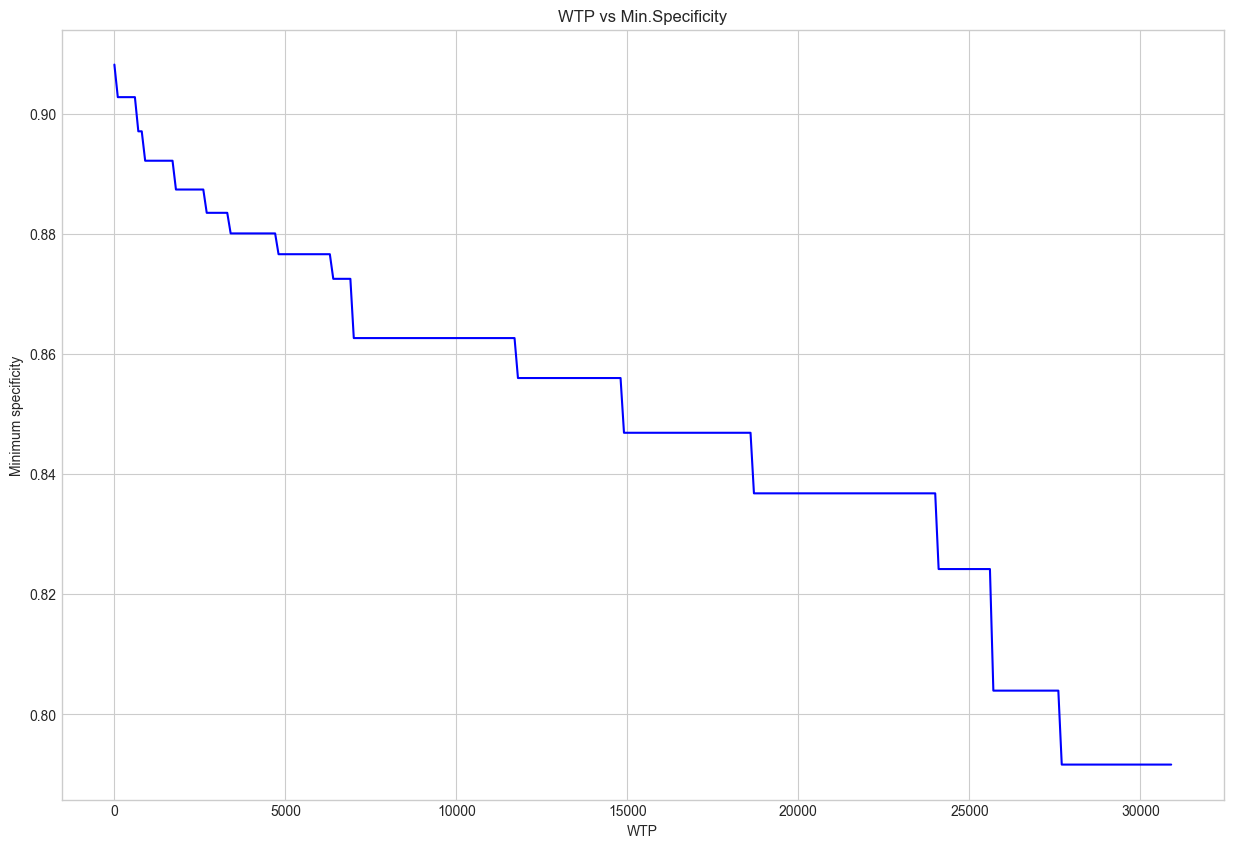

In [187]:
plt.figure(figsize=(15, 10))
plt.plot(WTP_list,Min_spe_list, 'b', linestyle="-")

plt.title('WTP vs Min.Specificity')
plt.xlabel('WTP')
plt.ylabel('Minimum specificity')
#plt.xlim((0, 1))
#plt.ylim((0, 1))

path = './Plot'
filename = "WTP vs Min_specificity_pre"+str(prev_name)+".pdf"
plotpath = os.path.join(path, filename)
plt.savefig(plotpath)
plt.show()

In [79]:
# Add 3-time GDP: 30828
WTP_list.append(30828)
Min_spe_list.append(Compute_ICER(table_sort_origin,30828)[0])

# Save table after selection
WTP_reult = pd.DataFrame({'WTP':WTP_list,'Min_spe':Min_spe_list})
outputpath='./DataForPy/table_sortR0-R4_pre'+str(prev_name)+'_WTP'+str(WTP)+'_ICERselect.csv'
WTP_reult.to_csv(outputpath,sep=',',index=False,header=True)

In [80]:
# Save ICER result at WTP=30828
ICER_result = Compute_ICER(table_sort_origin,30828)[1]

outputpath='./DataForPy/table_sortR0-R4_pre'+str(prev_name)+'_3GDPWTP_ICERresult.csv'
ICER_result.to_csv(outputpath,sep=',',index=False,header=True)

## 9 Draw Effect of sensitivity/specificity on ICER/cost/effectiveness

In [71]:
table_effect = pd.read_csv('./DataForPy/table_sortR0-R4.csv')
#table_effect = Compute_ICER(table_sort,30828)[1]

In [72]:
table_effect['Incre.Sen'] = ""
table_effect['Incre.Spe'] = ""
table_effect['Incre.Cost'] = ""
table_effect['Incre.Effect'] = ""
table_effect['ICER_new'] = ""
table_effect['Incre.Sen_per_cost'] = ""
table_effect['Incre.Spe_per_cost'] = ""

for i in range(len(table_effect.index)):
    if i >0:
        table_effect.loc[table_effect.index[i],'Incre.Sen'] = table_effect.loc[table_effect.index[i],'Sensitivity'] - table_effect.loc[table_effect.index[0],'Sensitivity']
        table_effect.loc[table_effect.index[i],'Incre.Spe'] = table_effect.loc[table_effect.index[i],'Specificity'] - table_effect.loc[table_effect.index[0],'Specificity']
        table_effect.loc[table_effect.index[i],'Incre.Cost'] = table_effect.loc[table_effect.index[i],'Cost'] - table_effect.loc[table_effect.index[0],'Cost']
        table_effect.loc[table_effect.index[i],'Incre.Effect'] = table_effect.loc[table_effect.index[i],'Effect'] - table_effect.loc[table_effect.index[0],'Effect']
        table_effect.loc[table_effect.index[i],'ICER_new'] = table_effect.loc[table_effect.index[i],'Incre.Cost']/table_effect.loc[table_effect.index[i],'Incre.Effect']
        table_effect.loc[table_effect.index[i],'Incre.Sen_per_cost'] = table_effect.loc[table_effect.index[i],'Incre.Sen']/table_effect.loc[table_effect.index[i],'Incre.Cost']
        table_effect.loc[table_effect.index[i],'Incre.Spe_per_cost'] = table_effect.loc[table_effect.index[i],'Incre.Spe']/table_effect.loc[table_effect.index[i],'Incre.Cost']

table_effect = table_effect.drop(table_effect.index[0])
table_effect = table_effect.sort_values(['Incre.Cost'],ascending=True, inplace=False)
#table_effect

In [76]:
outputpath='./DataForPy/Threshold_CEA_Result_prev'+str(prev_name)+'_IncreSenSpe_vs_IncreEffect.csv'
table_effect.to_csv(outputpath,sep=',',index=False,header=True)

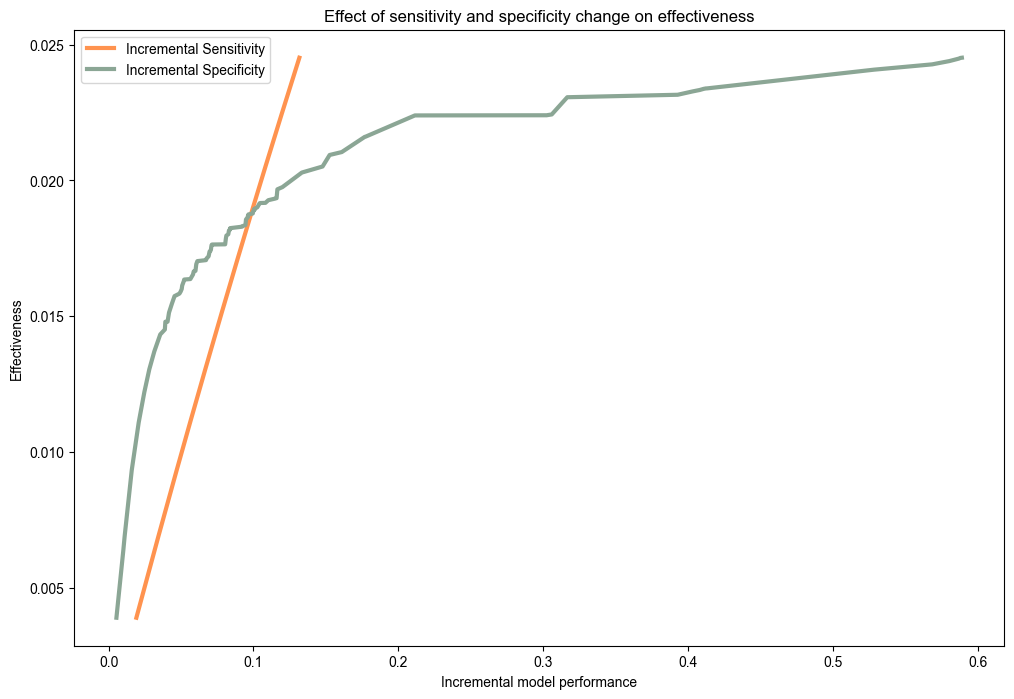

In [74]:
x1 = table_effect['Incre.Sen'].values
x2 = table_effect['Incre.Spe'].values
y1 = min(table_effect['Incre.Effect'])
y2 = table_effect['Incre.Effect'].values

plt.figure(figsize=(12, 8))
#plt.plot(abs(x1),y2, '#C16E70', linestyle="-",linewidth = 3) # red
plt.plot(abs(x1),y2, '#FF934F', linestyle="-",linewidth = 3) # orange
#plt.fill_between(abs(x1).astype(np.float64),y1,y2.astype(np.float64),facecolor = 'blue',alpha = 0.2)
#plt.plot(abs(x2),y2, '#6699CC', linestyle="-",linewidth = 3) # blue
plt.plot(abs(x2),y2, '#8BA695', linestyle="-",linewidth = 3) # green
#plt.fill_between(abs(x2).astype(np.float64),y1,y2.astype(np.float64),facecolor = 'g',alpha = 0.2)

plt.title('Effect of sensitivity and specificity change on effectiveness')
plt.xlabel('Incremental model performance')
plt.ylabel('Effectiveness')
plt.legend(['Incremental Sensitivity','Incremental Specificity'])
plt.style.use('seaborn-whitegrid')

#plt.xlim((0, 1))
#plt.ylim((0, 1))

path = './Plot'
filename = "Performance vs Effect_prev"+str(prev_name)+".pdf"
plotpath = os.path.join(path, filename)
plt.savefig(plotpath)

plt.show()

In [75]:
table_effect

,FN,FP,R0,R1,R2,R3,R4,Sensitivity,Specificity,TN,...,Cost,Effect,Incre.Cost,Incre.Effect,ICER,Incre.Sen,Incre.Spe,ICER_new,Incre.Sen_per_cost,Incre.Spe_per_cost
1,1827.0,22958.0,0.0,0.0,0.9,0.2,0.8,0.881610,0.902763,213145.0,...,8028.772231,12.978982,1.6004,0.00388972,4.114431e+02,0.0191967,-0.00542365,411.443,0.0119949,-0.00338893
2,1671.0,24043.0,0.0,0.0,0.9,0.2,0.7,0.894133,0.898015,211708.0,...,8031.628616,12.981456,4.45678,0.00636456,1.154169e+03,0.0317203,-0.0101711,700.25,0.00711731,-0.00228217
3,1636.0,24257.0,0.0,0.0,0.9,0.1,0.9,0.896860,0.897073,211416.0,...,8032.129004,12.981989,4.95717,0.00689708,9.396599e+02,0.0344475,-0.0111129,718.735,0.00694901,-0.00224179
4,1470.0,25371.0,0.0,0.0,0.9,0.1,0.8,0.909460,0.892175,209928.0,...,8035.261486,12.984420,8.08965,0.0093284,1.288389e+03,0.0470475,-0.0160109,867.207,0.00581576,-0.00197919
5,1362.0,26317.0,0.0,0.0,0.9,0.1,0.7,0.917404,0.888034,208728.0,...,8038.770740,12.985929,11.5989,0.0108372,2.325919e+03,0.0549915,-0.0201522,1070.29,0.0047411,-0.00173742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,159.0,152894.0,0.9,0.5,0.0,0.0,0.0,0.993789,0.323283,73041.0,...,8820.903461,12.999550,793.732,0.0244584,9.846156e+04,0.131376,-0.584903,32452.2,0.000165517,-0.000736903
136,155.0,153348.0,0.9,0.6,0.0,0.0,0.0,0.993953,0.321178,72555.0,...,8823.856149,12.999578,796.684,0.024486,1.070148e+05,0.13154,-0.587009,32536.3,0.000165109,-0.000736815
137,151.0,153616.0,0.9,0.7,0.0,0.0,0.0,0.994114,0.319925,72265.0,...,8825.595594,12.999605,798.424,0.0245132,6.411543e+04,0.131701,-0.588261,32571.2,0.000164951,-0.000736778
138,150.0,153765.0,0.9,0.8,0.0,0.0,0.0,0.994155,0.319238,72107.0,...,8826.561989,12.999612,799.39,0.0245201,1.398859e+05,0.131742,-0.588948,32601.5,0.000164803,-0.000736747


In [343]:
# Draw WTP vs min specificity plot

# Read WTP Data
p1 = pd.read_csv("./DataForPy/table_sortR0-R4_pre3.72_WTP30900_ICERselect.csv")
p1 = p1.rename(columns={'Min_spe':'3.72%'})

p2 = pd.read_csv("./DataForPy/table_sortR0-R4_pre5.58_WTP30900_ICERselect.csv")
p2 = p2.rename(columns={'Min_spe':'5.58%'})

p3 = pd.read_csv("./DataForPy/table_sortR0-R4_pre7.44_WTP30900_ICERselect.csv")
p3 = p3.rename(columns={'Min_spe':'7.44%'})

p4 = pd.read_csv("./DataForPy/table_sortR0-R4_pre9.3_WTP30900_ICERselect.csv")
p4 = p4.rename(columns={'Min_spe':'9.30%'})

p5 = pd.read_csv("./DataForPy/table_sortR0-R4_pre11.16_WTP30900_ICERselect.csv")
p5 = p5.rename(columns={'Min_spe':'11.16%'})

In [347]:
prevalence_plot = pd.merge(p1,p2,how = 'inner',on = 'WTP')
prevalence_plot = pd.merge(prevalence_plot,p3,how = 'inner',on = 'WTP')
prevalence_plot = pd.merge(prevalence_plot,p4,how = 'inner',on = 'WTP')
prevalence_plot = pd.merge(prevalence_plot,p5,how = 'inner',on = 'WTP')
prevalence_plot

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(,Min_spe_list, 'b', linestyle="-")

plt.title('WTP vs Min.Specificity')
plt.xlabel('WTP')
plt.ylabel('Minimum specificity')
#plt.xlim((0, 1))
#plt.ylim((0, 1))

path = './Plot'
filename = "WTP vs Min_specificity_pre"+str(prev_name)+".pdf"
plotpath = os.path.join(path, filename)
plt.savefig(plotpath)
plt.show()

### Figure 3. Levelplot: Impact of sensitivity and specificity on cost & effectiveness

In [40]:
table_LevelPlot = pd.DataFrame()
n = 0
for sen in range(860,1000,2):
    for spe in range(800,1000,2):
        sensitivity = sen/1000
        specificity = spe/1000
        COST_EFFECT = CEA_Calculation(sensitivity,specificity)
        result = {"Sensitivity":sensitivity,"Specificity":specificity,"Cost":COST_EFFECT[0],"Effect":COST_EFFECT[1]}
        table_LevelPlot = table_LevelPlot.append(result,ignore_index = True)
        
        n +=1
        
        # Show progress
        i = int(n*(100/7000))
        if __name__ == '__main__':
            progress_bar()

outputpath='./DataForPy/Threshold_CEA_Result_prev7.44'+'_LevelPlot.csv'
table_LevelPlot.to_csv(outputpath,sep=',',index=False,header=True)

Running progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋